In [1]:
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import scipy.optimize as opt

### 1. Load and Preprocess the data
We are going to work with the [Folktables](https://github.com/socialfoundations/folktables#quick-start-examples) dataset (*you have already worked with it*).

1. As last week, we are still predicting the *Total person's income*  (I've digitized  it in  `target_transform=lambda x: x > 25000`).
2. Today, we are going to implement two methods for data debiasing: [Fair PCA](https://deepai.org/publication/efficient-fair-pca-for-fair-representation-learning) and [A Geometric Solution to Fair Representations](https://dl.acm.org/doi/10.1145/3375627.3375864).
3. We are going to evaluate the performance on two sensitive features: `SEX` (i.e. *Males* and *Females*) and `RAC1P` (we will consider only *Whites* and *African-Americans*)
4. I updated the filtering method `adult_filter` to keep the specified groups.

In [8]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'CIT',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P'
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', "RAC1P"],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
# acs_data = acs_data.sample(500, random_state=0)

# 1.2 Proxies

In [10]:
from sklearn.model_selection import train_test_split
data = ACSIncomeNew.df_to_pandas(acs_data)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data[0], data[1], data[2], test_size=0.2, random_state=0)

In [54]:
import pandas as pd
african_american = X_train[X_train['RAC1P'] == 2]
whites = X_train[X_train['RAC1P'] == 1]

from sklearn.utils import resample
african_american = resample(african_american,
                            replace=True,
                            n_samples=len(whites),
                            random_state=0)
oversampled_df = pd.concat([african_american,whites]).reset_index(drop=True)

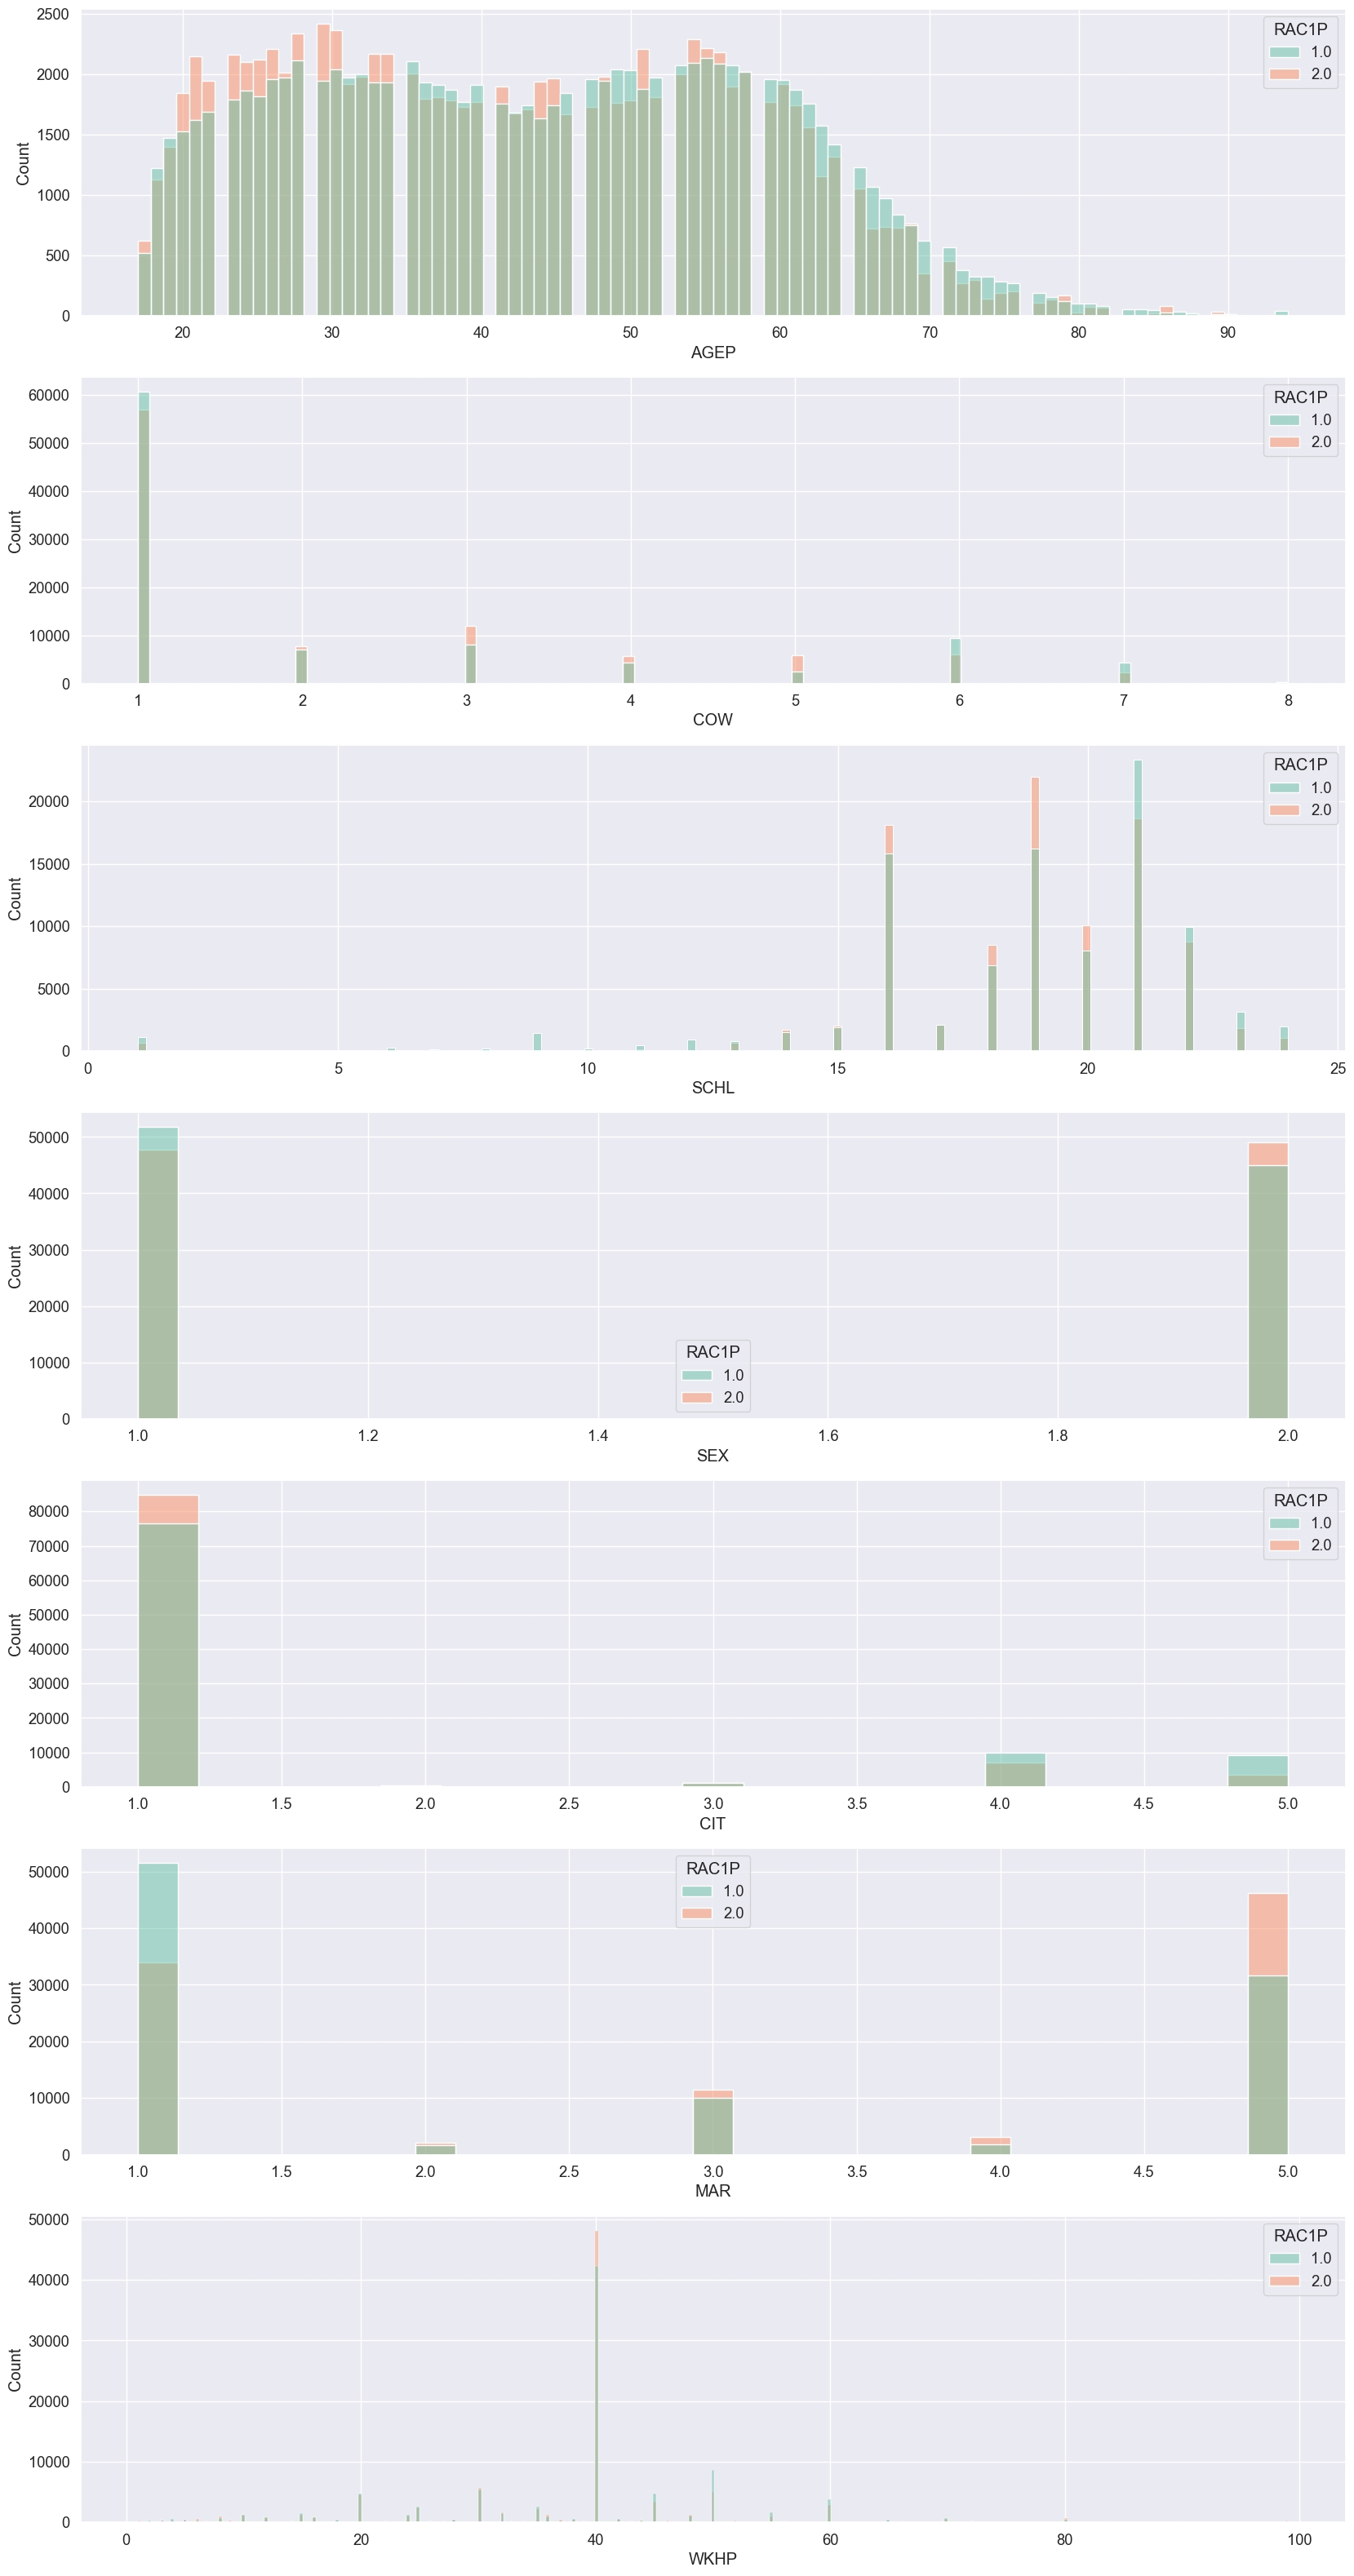

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot feature distributions for both genders in one plot
fig, axes = plt.subplots(7, figsize=(20, 40))
for i, feature in enumerate(['AGEP', 'COW', 'SCHL', 'SEX', 'CIT', 'MAR','WKHP']):
    sns.histplot(data=oversampled_df, x=feature, hue='RAC1P', ax=axes[i], palette='Set2')
plt.show()

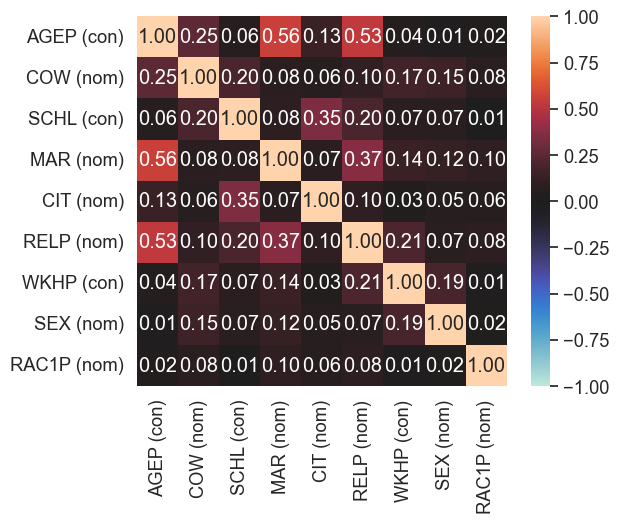

In [64]:
import dython
dython.nominal.associations(X_train, nominal_columns=['COW', 'CIT', 'RAC1P', 'SEX', 'RELP', 'MAR'], mark_columns=True);

# 2.1 Data

In [18]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)
### groups now contain information about SEX and RAC1P

In [20]:
# Drop the "redundant" columns
features = features.drop(["RELP_Unmarried partner",
                          "CIT_U.S. citizen by naturalization",
                          "SEX_Male",
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm', 
                          "RAC1P_White alone" ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)

Columns with the protected features:
Column ID: 56 (SEX_Female)
Column ID: 57 (RAC1P_Black or African American alone)


In [138]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

N = 500 ### I am subsampling because it is slow on my machine

X_train = X_train[:N]
y_train = y_train[:N]
group_train = group_train[:N]
X_test = X_test[:N]
y_test = y_test[:N]
group_test = group_test[:N]

In [139]:
## last columns of our data contains the protected features
protected = X_train[:,57:] 
nonprotected = X_train[:,:57]

#### Task 2.2.
Use the following arguments in the `opt.fmin_funct`: `xtol=1e-4, ftol=1e-4,  maxfun=1000`

In [71]:
gammas = np.logspace(1e-5,1e-2,10)
###########
# YOUR CODE
###########

In [72]:
def sigmoid(x):
    """
    This is logistic regression
    f = 1/(1+exp(-beta^T * x))
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1/(1+np.exp(-x))

def logistic_loss(y_true, y_pred, eps = 1e-9):
    """
    Loss for the logistic regression, y_preds are probabilities
    eps: epsilon for stability
    """
    # check whether that's the same as 1/m * sum()
    return -np.mean(y_true*np.log(y_pred + eps)+(1-y_true)*np.log(1-y_pred + eps))
    
def l2_loss(beta):
    """
    L2-Regularisation
    """
    return np.linalg.norm(beta)

def compute_gradient(beta, X, y_true, _gamma): # y = y_true
    """Calculate the gradient - used for finding the best beta values. 
       You do not need to use groups and lambda (fmin_tnc expects same input as in func, that's why they are included here)"""
    grad = np.zeros(beta.shape)
    m = X.shape[0]
    y_pred = np.array(sigmoid(X.dot(beta))) # same as beta @ X.T?
    
    for i in range(len(grad)):
        if i == 0:
            # don't want to penalize the intercept
            grad[i] = (1/m) * (y_pred - y_true).dot(X[:,i]) 
        else:
            # start with beta[1]
            grad[i] = (1/m) * (y_pred - y_true).dot(X[:,i]) + 2* _gamma *beta[i] 
    #print(f'Gradient: {grad}')
    return grad

def compute_cost(beta , X, y_true, grouping, _lambda, _gamma):
    """Computes cost function with constraints"""
    y_pred = sigmoid(X.dot(beta)) 
    cost = logistic_loss(y_true, y_pred) + _gamma*l2_loss(beta[1:]) # to not penalize the Intercept?
    #print(f'Cost: {cost}')
    return cost

beta = np.random.rand(X_train.shape[1])
# set parameters
lambda_ = 0.1
gamma_ = 0.1
#
X = X_train
y = y_train
groups = group_train

beta = np.random.rand(57)
lambdas = np.linspace(1,1e5, 20)

########## This is the optimisation function

result = opt.fmin_tnc(func=compute_cost, x0=beta, approx_grad = True, maxfun = 1000,
                         args = (nonprotected,y_train, groups, lambdas[0], gammas[2]), ftol=1e-4, xtol=1e-4)

  NIT   NF   F                       GTG
    0    1  1.087440762991035E+01   1.01032141E+00
    1    9  7.080237454427224E+00   2.29428814E+00
/var/folders/pj/yc7yqjf95rz_5hfdwlpnmh6m0000gp/T/ipykernel_54941/1383051056.py:7: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
    2   25  4.046029290079790E+00   1.79364593E+01
    3   34  4.028325661968031E+00   2.15674989E+01
    4   67  3.778330230081710E+00   2.20802467E+01
    5   77  3.769227839847745E+00   2.14326814E+01
    6   79  3.767075961614881E+00   2.14053457E+01
    7   90  3.764090828879687E+00   2.15635073E+01
    8   96  3.758836552397650E+00   2.09595850E+01
    9  100  3.755333649262979E+00   2.11897122E+01
   10  106  3.754866244562694E+00   2.07905179E+01
   11  111  1.772112036469401E+00   1.18871105E+02
   12  117  1.759960373431385E+00   1.43159939E+02
tnc: fscale = 0.0479398
   13  121  1.396055145146141E+00   1.09286159E+01
   14  140  1.385071466731997E+00   9.89854629E+00
   15  144  8.1106

In [97]:
from sklearn.model_selection import KFold

# Define a list of values for lambda to try
lambdas = np.linspace(1, 1e5, 20)

# Initialize an array to store the cross-validation errors for each lambda value
cv_errors = np.zeros(len(lambdas))

# Define the number of folds for K-fold cross-validation
num_folds = 5

# Create the KFold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Loop over each lambda value
for i, lambda_val in enumerate(lambdas):
    
    # Initialize an array to store the prediction errors for each fold
    fold_errors = np.zeros(num_folds)
    
    # Loop over each fold
    for j, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        
        # Split the data into training and validation sets for this fold
        X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
        X_fold_val, y_fold_val = X_train[val_idx], y_train[val_idx]
        
        # Train the logistic regression model with L2-regularization on the training data for this fold
        beta = np.random.rand(X_train.shape[1])
        result = opt.fmin_tnc(func=compute_cost, x0=beta, approx_grad=True, maxfun=1000,
                              args=(X_fold_train, y_fold_train, group_train, lambda_val, gamma_), 
                              ftol=1e-4, xtol=1e-4)
        beta_opt = result[0]
        
        # Make predictions on the validation data and calculate the prediction error
        y_pred = sigmoid(X_fold_val.dot(beta_opt))
        fold_errors[j] = logistic_loss(y_fold_val, y_pred)
        
    # Calculate the average prediction error for this lambda value
    cv_errors[i] = np.mean(fold_errors)
    
# Find the lambda value with the lowest cross-validation error
best_lambda = lambdas[np.argmin(cv_errors)]

# Train the logistic regression model on the entire training data with the best lambda value
beta = np.random.rand(X_train.shape[1])
result = opt.fmin_tnc(func=compute_cost, x0=beta, approx_grad=True, maxfun=1000,
                      args=(X_train, y_train, group_train, best_lambda, gamma_), 
                      ftol=1e-4, xtol=1e-4)
beta_opt = result[0]

# Make predictions on the test data
y_pred_test = sigmoid(X_test.dot(beta_opt))
test_error = logistic_loss(y_test, y_pred_test)


  NIT   NF   F                       GTG
    0    1  6.727979664774644E+00   3.45554038E-01
    1   16  5.500594512329505E+00   4.14266788E+00


#### Task 2.3
Use the following arguments in the `opt.fmin_funct`: ` xtol=1e-3, ftol=1e-3, approx_grad=True, maxfun=1000`

In [95]:
lambdas = np.array([1e-3, 5e-3, 1e-2, 5e-2, 0.1, 1])
###########
# YOUR CODE
###########

In [75]:
### CODE FROM HANNAH
def sigmoid(x):
    """
    This is logistic regression
    f = 1/(1+exp(-beta^T * x))
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1/(1+np.exp(-x))

def logistic_loss(y_true, y_pred, eps = 1e-9):
    """
    Loss for the logistic regression, y_preds are probabilities
    eps: epsilon for stability
    """
    # check whether that's the same as 1/m * sum()
    return -np.mean(y_true*np.log(y_pred + eps)+(1-y_true)*np.log(1-y_pred + eps))
    
def l2_loss(beta):
    """
    L2-Regularisation
    """
    return np.linalg.norm(beta)

def fair_loss(y_true, y_pred, grouping):
    """
    Group fairness Loss
    """
    n = y_true.shape[0]
    
    # SEX
    n1 = np.sum(grouping['SEX'] == 1)
    n2 = n - n1

    cost_sex = 0
    for i in range(n):
        for j in range(i+1, n):
            if y_true[i] == y_true[j]:
                if grouping['SEX'].iloc[i] != grouping['SEX'].iloc[j]:
                    cost_sex += (y_pred[i] - y_pred[j])**2                
    cost_sex = cost_sex/(n1*n2)
    # print(cost_sex)
    
    # RAC1P
    n1 = np.sum(grouping['RAC1P'] == 1)
    n2 = n - n1

    cost_race = 0
    for i in range(n):
        for j in range(i+1, n):
            if y_true[i] == y_true[j]:
                if grouping['RAC1P'].iloc[i] != grouping['RAC1P'].iloc[j]:
                    cost_race += (y_pred[i] - y_pred[j])**2                
    cost_race = cost_race/(n1*n2)
    # print(cost_race)
    
    # Is this right? Or how should the two fairness constraints be connected before applying the scaling?
    return cost_sex + cost_race


### not needed (?)
def compute_gradient(beta,X,y_true,_gamma): # y = y_true
    """Calculate the gradient - used for finding the best beta values. 
       You do not need to use groups and lambda (fmin_tnc expects same input as in func, that's why they are included here)"""
    grad = np.zeros(beta.shape)
    m = X.shape[0]
    y_pred = np.array(sigmoid(X.dot(beta))) # same as beta @ X.T?
    
    for i in range(len(grad)):
        if i == 0:
            # don't want to penalize the intercept
            grad[i] = (1/m) * (y_pred - y_true).dot(X[:,i]) 
        else:
            # start with beta[1]
            grad[i] = (1/m) * (y_pred - y_true).dot(X[:,i]) + 2* _gamma *beta[i] 
    #print(f'Gradient: {grad}')
    return grad


def compute_cost(beta , X, y_true, grouping, _lambda, _gamma):
    """Computes cost function with constraints"""
    y_pred = sigmoid(X.dot(beta)) 
    cost = logistic_loss(y_true, y_pred) + _lambda*fair_loss(y_true, y_pred, grouping) + _gamma*l2_loss(beta[1:]) # to not penalize the Intercept?
    #print(f'Cost: {cost}')
    return cost

In [76]:
'''np.random.seed(0)
lambdas = np.array([1e-3, 5e-3, 1e-2, 5e-2, 0.1, 1])
betas = np.random.rand(X_train.shape[1])

opt.fmin_tnc(func=compute_cost, x0=beta, approx_grad = True, maxfun = 1000,
                         args = (nonprotected,y_train, groups, lambdas[0], gammas[2]), ftol=1e-3, xtol=1e-3)'''

  NIT   NF   F                       GTG
    0    1  1.087440762991035E+01   1.01032141E+00
    0    3  1.087440762991035E+01   1.01032141E+00
tnc: User requested end of minimization


KeyboardInterrupt: 

### Task 2.4: Fair PCA 

In [155]:
definition_df = data_source.get_definitions(download=True)
#categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data)
### groups now contain information about SEX and RAC1P
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

N = 500 ### I am subsampling because it is slow on my machine

X_train = X_train[:N]
y_train = y_train[:N]
group_train = group_train[:N]
X_test = X_test[:N]
y_test = y_test[:N]
group_test = group_test[:N]

In [194]:
protected = X_train[:,-2:]
nonprotected = X_train[:,:-2]

Text(0.5, 0, 'Principal Component')

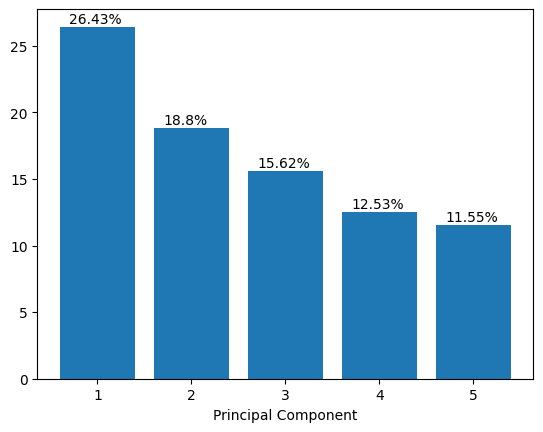

In [198]:
# pca 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
non_protected_features_scaled = scaler.fit_transform(nonprotected)

pca = PCA(n_components=len(features.columns)-4)
X_pca = pca.fit_transform(non_protected_features_scaled)

# pca.explained_variance_ratio_
# scree plot bar plot
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_*100)
for i in range(len(pca.explained_variance_ratio_)):
    plt.text(i+0.7, pca.explained_variance_ratio_[i]*100+0.3, str(round(pca.explained_variance_ratio_[i]*100,2))+'%')
plt.xlabel('Principal Component')

In [199]:
# plot the first three components interactive 3d
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=X_pca[:,0],
    y=X_pca[:,1],
    z=X_pca[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=['red' if x else 'blue' for x in y_train], # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])
fig.show()

WE SEE THAT THERE ARE NO CORRELATION BETWEEN ANY OF THE PCA COMPONENTS, WHICH MAKES SENSE SINCE PRINCIPAL COMPONENTS TRY TO COVER DIFFERENT ORTHAGONAL DIRECTIONS AND VARIANCE IN THE DATA.
Also Sex is slightly correlated PC3 and PC4, which can mean that they are somewhat proxies.


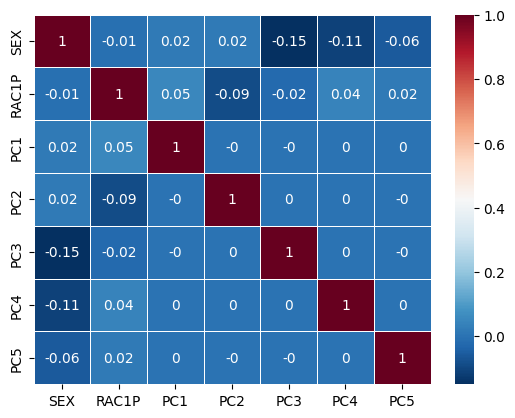

In [232]:
# corr matrix comparing protected
import seaborn as sns
import pandas as pd

df = pd.DataFrame(np.concatenate((protected, X_pca), axis=1))

corr = round(df.corr(),2)
corr.columns=['SEX', 'RAC1P', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5']
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5);

print(f'WE SEE THAT THERE ARE NO CORRELATION BETWEEN ANY OF THE PCA COMPONENTS, WHICH MAKES SENSE SINCE PRINCIPAL COMPONENTS TRY TO COVER DIFFERENT ORTHAGONAL DIRECTIONS AND VARIANCE IN THE DATA.')
print(f'Also Sex is slightly correlated PC3 and PC4, which can mean that they are somewhat proxies.')

### copied from chatgpt should be able to answer the next question somewhat with some changes

In [ ]:


import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Separate the non-protected features from the protected feature
non_protected_features_train = train_data[['feature1', 'feature2', 'feature3']]
non_protected_features_test = test_data[['feature1', 'feature2', 'feature3']]
protected_feature_train = train_data['protected_feature']
protected_feature_test = test_data['protected_feature']

# Standardize the non-protected features
scaler = StandardScaler()
non_protected_features_train_scaled = scaler.fit_transform(non_protected_features_train)
non_protected_features_test_scaled = scaler.transform(non_protected_features_test)

# Fit PCA on the training data
pca = PCA()
pca.fit(non_protected_features_train_scaled)

# Project the test data into the PCA space
test_data_pca = pca.transform(non_protected_features_test_scaled)

# Project the test data back into the original space
test_data_reconstructed = pca.inverse_transform(test_data_pca)

# Calculate the reconstruction error for each sample
reconstruction_error = np.mean(np.abs(non_protected_features_test_scaled - test_data_reconstructed), axis=1)

# Group the reconstruction errors by protected feature value
protected_group_0_errors = reconstruction_error[protected_feature_test == 0]
protected_group_1_errors = reconstruction_error[protected_feature_test == 1]

# Print the mean reconstruction error for each protected group
print('Mean reconstruction error for protected group 0:', np.mean(protected_group_0_errors))
print('Mean reconstruction error for protected group 1:', np.mean(protected_group_1_errors))
